In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = False

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [130]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [131]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [132]:
image = cv2.imread('images/flies_augmented.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

[ WARN:0@270044.204] global loadsave.cpp:248 findDecoder imread_('images/flies_augmented.png'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


TypeError: Image data of dtype object cannot be converted to float

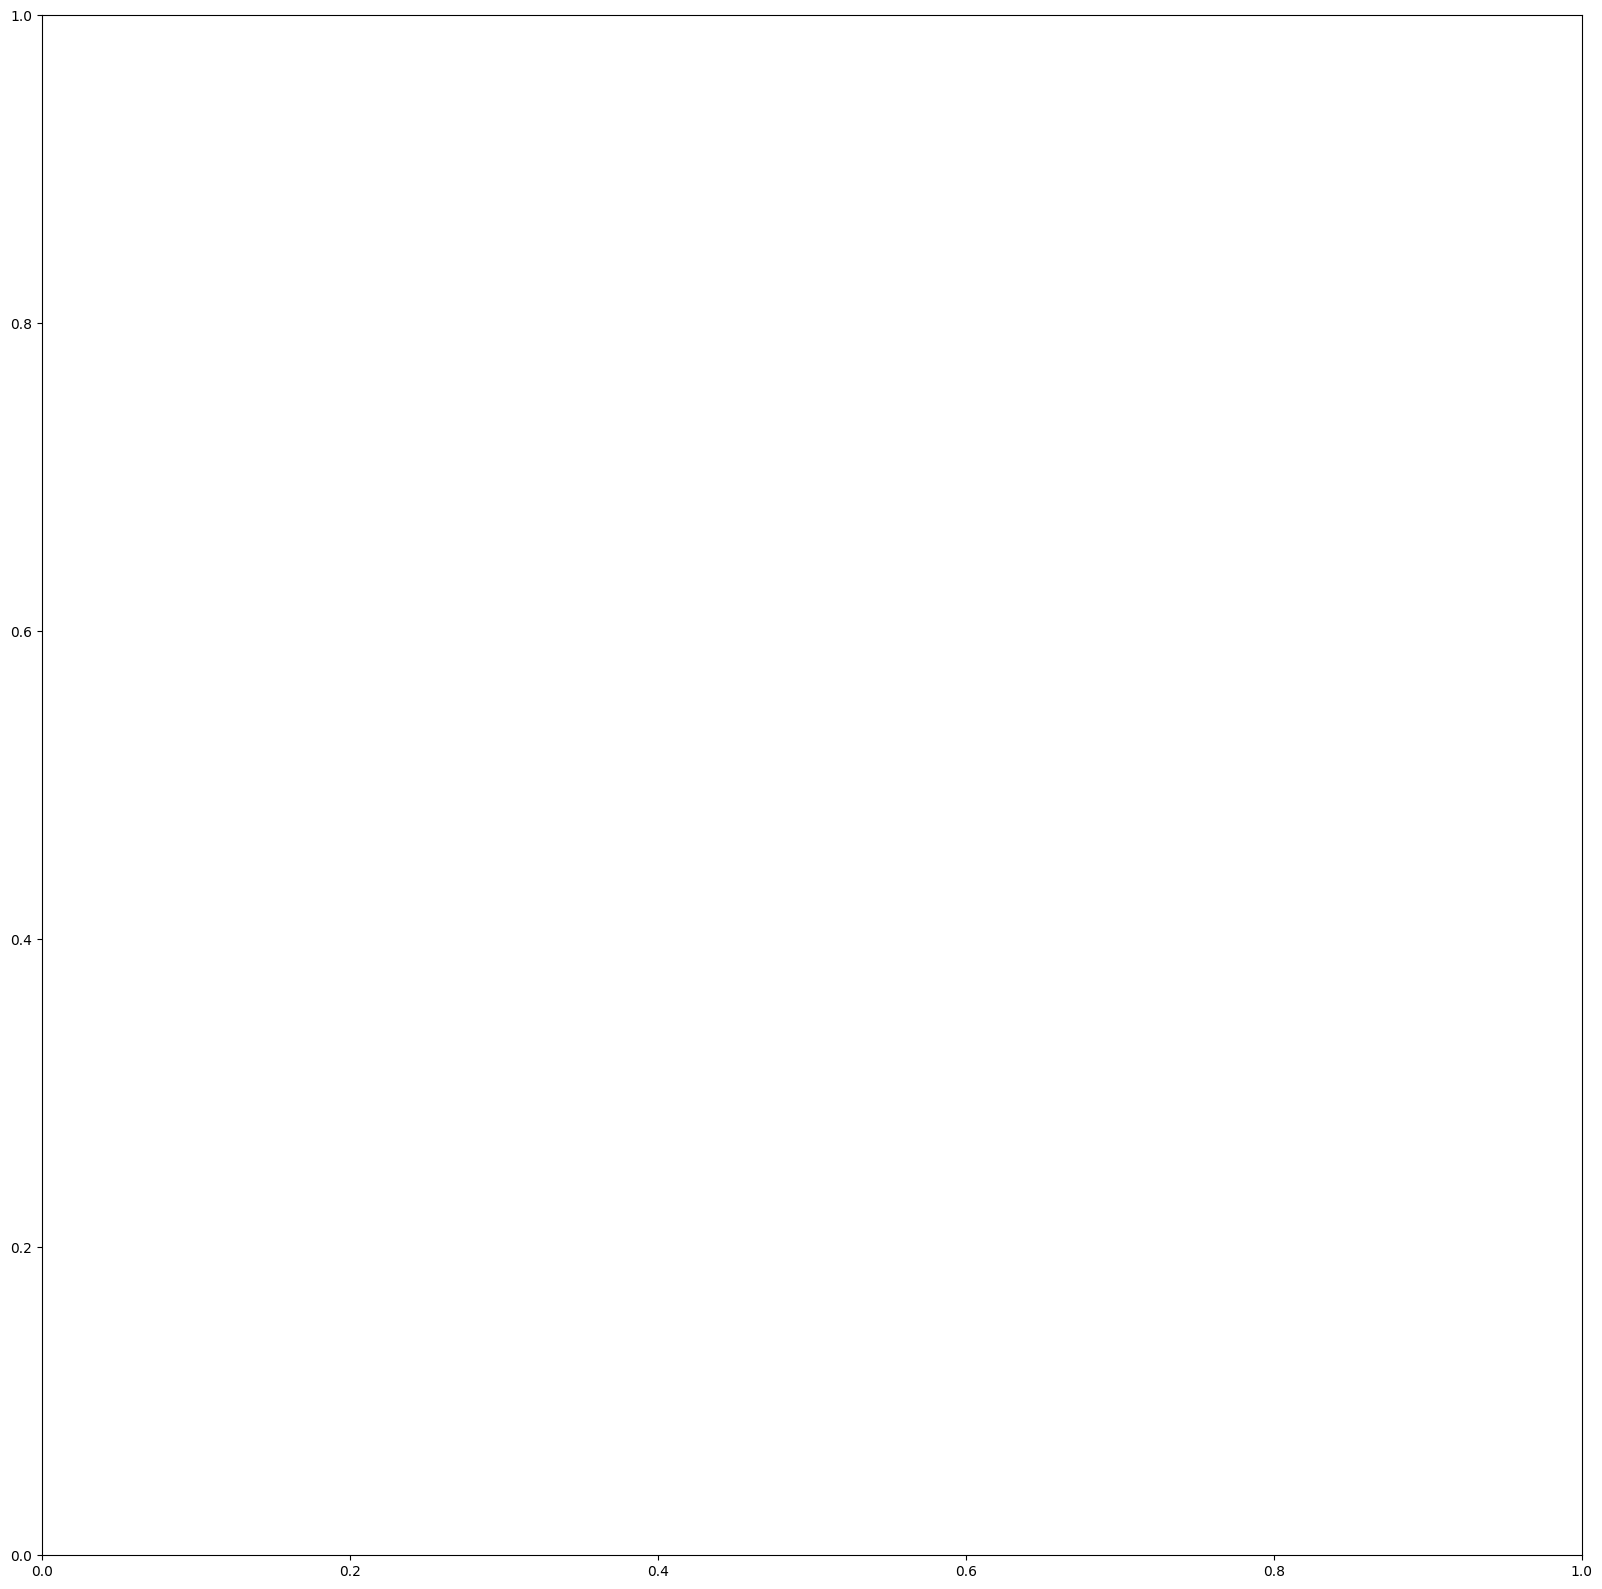

In [133]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [142]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
image = cv2.imread('../test_flies/2_grid_flies_0_raw_slice_0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
sam_checkpoint = "../model_checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

####### M1 acceleration in use but isn't good enough
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

device = 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam, box_nms_thresh=0.15, pred_iou_thresh=0.75)

To generate masks, just run `generate` on an image.

In [143]:
masks = mask_generator.generate(image)

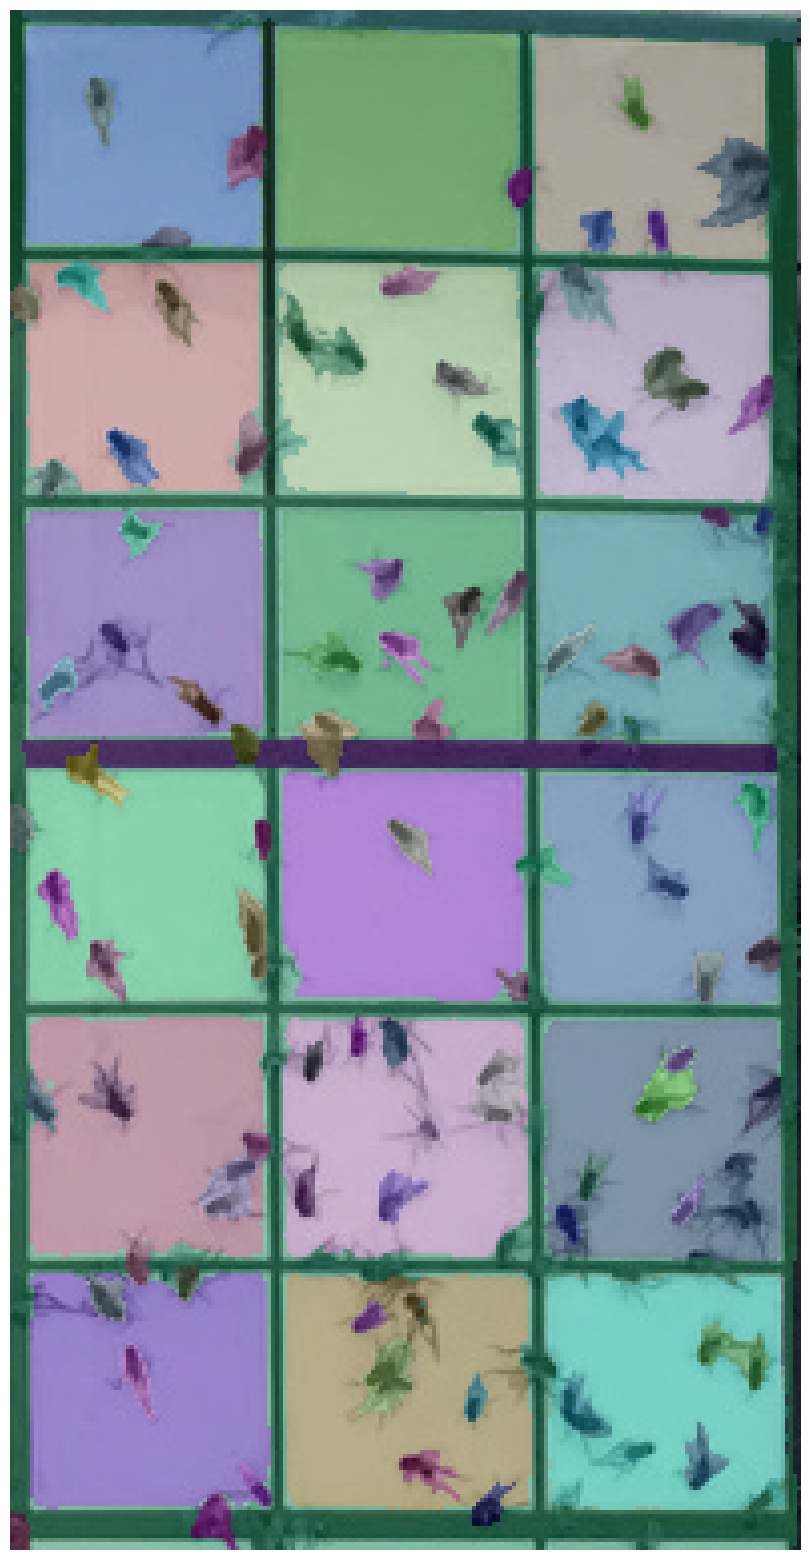

In [144]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
import pandas as pd

def filter_data_by_percentile(data, column_name, percentile_value):
    """
    Filter rows in the dataset based on the specified percentile of a given column.

    Parameters:
    - data (list of dicts): The dataset to process, represented as a list of dictionaries.
    - column_name (str): The name of the column to calculate the percentile for.
    - percentile_value (float): The percentile to calculate (e.g., 0.20 for the 20th percentile).

    Returns:
    - list of dicts: The filtered dataset, represented as a list of dictionaries.
    """
    # Convert list of dictionaries into a DataFrame
    df = pd.DataFrame(data)
    
    # Calculate the specified percentile of the given column
    percentile = df[column_name].quantile(percentile_value)
    
    # Filter the DataFrame to keep rows where the column's value is <= calculated percentile
    filtered_df = df[df[column_name] <= percentile]
    
    # Optional: Convert filtered DataFrame back to a list of dictionaries
    filtered_data = filtered_df.to_dict('records')
    
    # Return the filtered data
    return filtered_data


filtered_data = filter_data_by_percentile(masks, "area", 0.40)    
print(len(filtered_data))


Show all the masks overlayed on the image.

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(filtered_data)
plt.axis('off')
plt.show() 

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(filtered_data)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

# Import libraries and aux. functions

In [96]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd

def filter_data_by_percentile(data, column_name, percentile_value):
    """
    Filter rows in the dataset based on the specified percentile of a given column.

    Parameters:
    - data (list of dicts): The dataset to process, represented as a list of dictionaries.
    - column_name (str): The name of the column to calculate the percentile for.
    - percentile_value (float): The percentile to calculate (e.g., 0.20 for the 20th percentile).

    Returns:
    - list of dicts: The filtered dataset, represented as a list of dictionaries.
    """
    # Convert list of dictionaries into a DataFrame
    df = pd.DataFrame(data)
    
    # Calculate the specified percentile of the given column
    percentile = df[column_name].quantile(percentile_value)
    
    # Filter the DataFrame to keep rows where the column's value is <= calculated percentile
    filtered_df = df[df[column_name] <= percentile]
    
    # Optional: Convert filtered DataFrame back to a list of dictionaries
    filtered_data = filtered_df.to_dict('records')
    
    # Return the filtered data
    print(f"Total filtered objects are: {len(filtered_df[column_name])}")
    return filtered_data

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

##############
image = cv2.imread('images/flies_augmented.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

##############
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../model_checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

##### M1 acceleration in use but isn't good enough
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
# device = 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)



## Fine tuning parameters for detecting smaller objects

In [97]:
"""Arguments:


  model (Sam): The SAM model to use for mask prediction.

  points_per_side (int or None): The number of points to be sampled along one side of the image. The total number of points is
    points_per_side**2. If None, 'point_grids' must provide explicit point sampling.

  points_per_batch (int): Sets the number of points run simultaneously by the model. Higher numbers may be faster but use more GPU memory.

  pred_iou_thresh (float): A filtering threshold in [0,1], using the model's predicted mask quality.

  stability_score_thresh (float): A filtering threshold in [0,1], using the stability of the mask under changes to the cutoff used to binarize
    the model's mask predictions.

  stability_score_offset (float): The amount to shift the cutoff when calculated the stability score.

  box_nms_thresh (float): The box IoU cutoff used by non-maximal suppression to filter duplicate masks.

  crop_n_layers (int): If >0, mask prediction will be run again on crops of the image. Sets the number of layers to run, where each 
  layer has 2**i_layer number of image crops.

  crop_nms_thresh (float): The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.

  crop_overlap_ratio (float): Sets the degree to which crops overlap. In the first crop layer, crops will overlap by this fraction of
  the image length. Later layers with more crops scale down this overlap.

  crop_n_points_downscale_factor (int): The number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor**n.

  point_grids (list(np.ndarray) or None): A list over explicit grids of points used for sampling, normalized to [0,1]. The nth grid in the
    list is used in the nth crop layer. Exclusive with points_per_side.

  min_mask_region_area (int): If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller
    than min_mask_region_area. Requires opencv.

  output_mode (str): The form masks are returned in. Can be 'binary_mask',
    'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
    For large resolutions, 'binary_mask' may consume large amounts of
    memory.

###########
  model: Sam,
  points_per_side: Optional[int] = 32,
  points_per_batch: int = 64,
  pred_iou_thresh: float = 0.88,
  stability_score_thresh: float = 0.95,
  stability_score_offset: float = 1.0,
  box_nms_thresh: float = 0.7,
  crop_n_layers: int = 0,
  crop_nms_thresh: float = 0.7,
  crop_overlap_ratio: float = 512 / 1500,
  crop_n_points_downscale_factor: int = 1,
  point_grids: Optional[List[np.ndarray]] = None,
  min_mask_region_area: int = 0,
  output_mode: str = "binary_mask",    
"""

'Arguments:\n\n\n  model (Sam): The SAM model to use for mask prediction.\n\n  points_per_side (int or None): The number of points to be sampled along one side of the image. The total number of points is\n    points_per_side**2. If None, \'point_grids\' must provide explicit point sampling.\n\n  points_per_batch (int): Sets the number of points run simultaneously by the model. Higher numbers may be faster but use more GPU memory.\n\n  pred_iou_thresh (float): A filtering threshold in [0,1], using the model\'s predicted mask quality.\n\n  stability_score_thresh (float): A filtering threshold in [0,1], using the stability of the mask under changes to the cutoff used to binarize\n    the model\'s mask predictions.\n\n  stability_score_offset (float): The amount to shift the cutoff when calculated the stability score.\n\n  box_nms_thresh (float): The box IoU cutoff used by non-maximal suppression to filter duplicate masks.\n\n  crop_n_layers (int): If >0, mask prediction will be run again 

In [75]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.70,
    stability_score_thresh=0.92,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

## Generate masks, filter bboxes, show

In [76]:
masks = mask_generator_2.generate(image)

In [98]:
filtered_data = filter_data_by_percentile(masks, "area", 0.80)

Total filtered objects are: 311


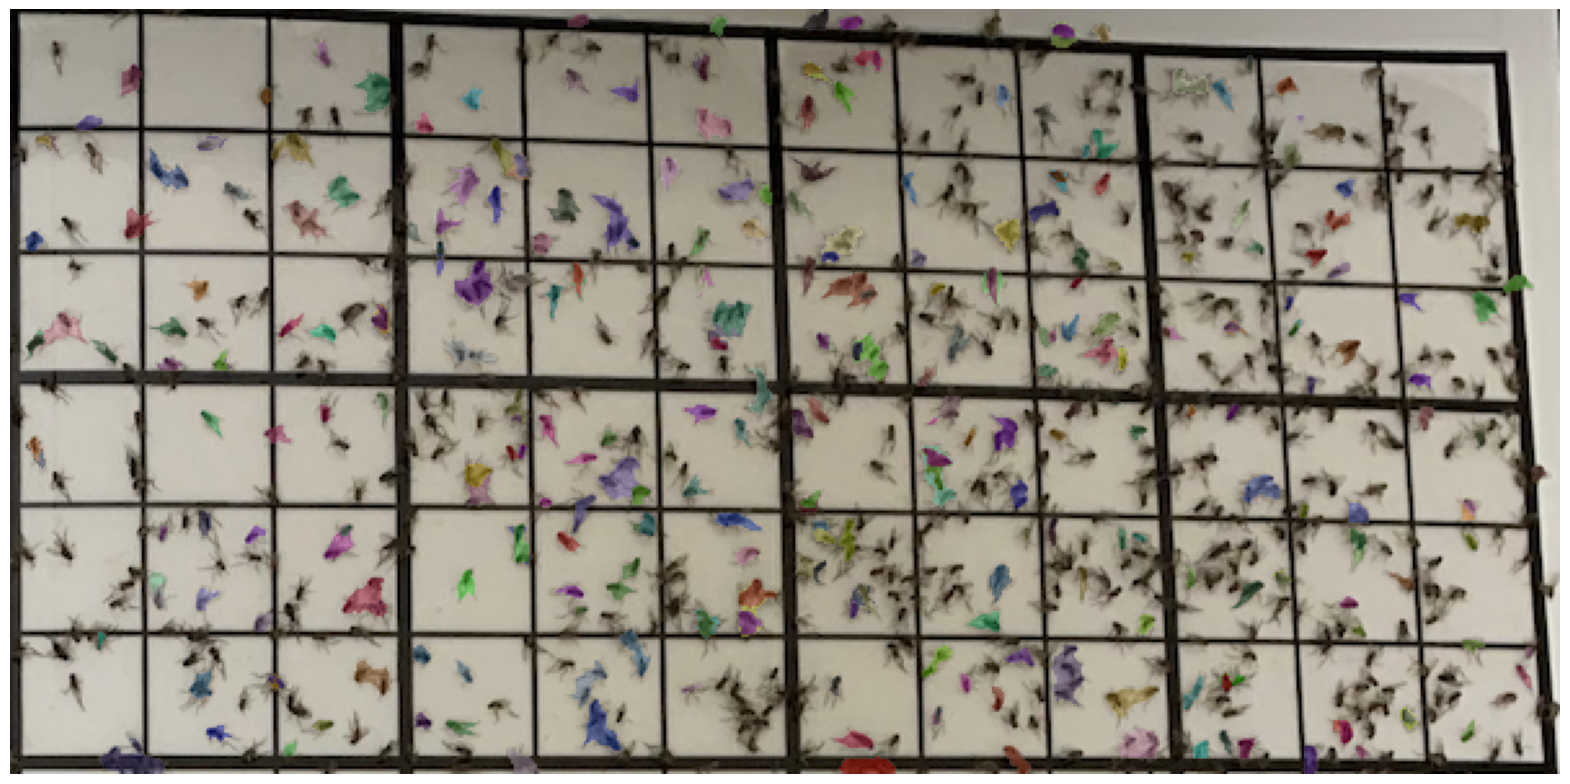

In [99]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(filtered_data)
plt.axis('off')
plt.show() 

## Test Routine

In [100]:
import time

def SAM_init(points_per_side: int, points_per_batch: int, pred_iou_thresh:float, crop_n_layers: int):
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=points_per_side,
        points_per_batch=points_per_batch,
        pred_iou_thresh=pred_iou_thresh,
        stability_score_thresh=0.92,
        crop_n_layers=crop_n_layers,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100,  # Requires open-cv to run post-processing
    )
    return mask_generator

points_per_side = [32,64,128]
points_per_batch = [32,64,128]
pred_iou_thresh = [0.65, 0.7, 0.8]
crop_n_layers = [1,2,3]

total_masks = []
for i in range(3):
    start = time.time()
    mask_generator = SAM_init(points_per_side=points_per_side[i], points_per_batch=points_per_batch[i], pred_iou_thresh=pred_iou_thresh[i], crop_n_layers=crop_n_layers[i])
    masks = mask_generator.generate(image)
    print(f"For points_per_side:{points_per_side[i]}, points_per_batch: {points_per_batch[i]}, pred_iou_thresh: {pred_iou_thresh[i]}, and crop_n_layers: {crop_n_layers[i]}")
    print(f"Time spent: {start - time.time()} seconds")
    total_masks.append(masks)


For points_per_side:32, points_per_batch: 32, pred_iou_thresh: 0.65, and crop_n_layers: 1
Time spent: -340.6482768058777 seconds


KeyboardInterrupt: 

In [102]:
# Call the function with the image and model.
init_sam = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,  # Increased resolution for small objects
    points_per_batch=128,  # Increased batch size if GPU can handle it
    pred_iou_thresh=0.5,  # Lower IoU threshold for small object detection
    stability_score_thresh=0.9,  # High threshold for stable detections
    stability_score_offset=0.1,  # Small offset for stability score calculation
    box_nms_thresh=0.3,  # Lower NMS threshold for separating close objects
    crop_n_layers=0,  # No additional crop layers
    crop_nms_thresh=0.7,  # Default value, not used if crop_n_layers is 0
    crop_overlap_ratio=512 / 1500,  # Default value, not used if crop_n_layers is 0
    crop_n_points_downscale_factor=1,  # No downscale, using single layer detection
    point_grids=None,  # No custom point grids
    min_mask_region_area=10,  # Minimum area for detected objects
    output_mode="binary_mask"  # Binary mask for post-processing
)
masks = init_sam.generate(image)

In [103]:
filtered_data_list = [masks]
for mask in total_masks:
    filtered_data = filter_data_by_percentile(masks, "area", 0.80)
    filtered_data_list.append(filtered_data)

Total filtered objects are: 343


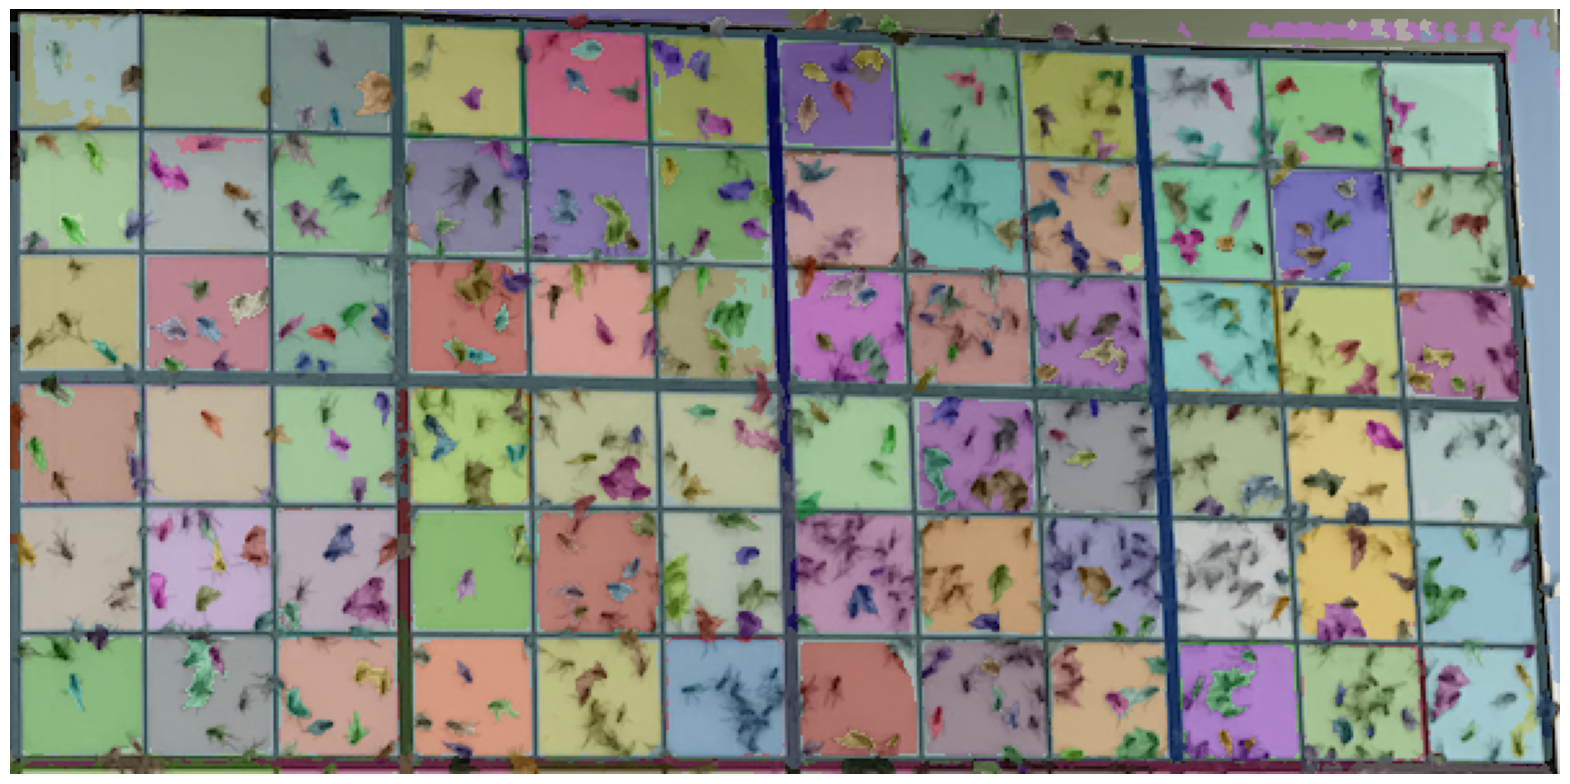

In [104]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(filtered_data_list[0])
plt.axis('off')
plt.show() 

Total filtered objects are: 347


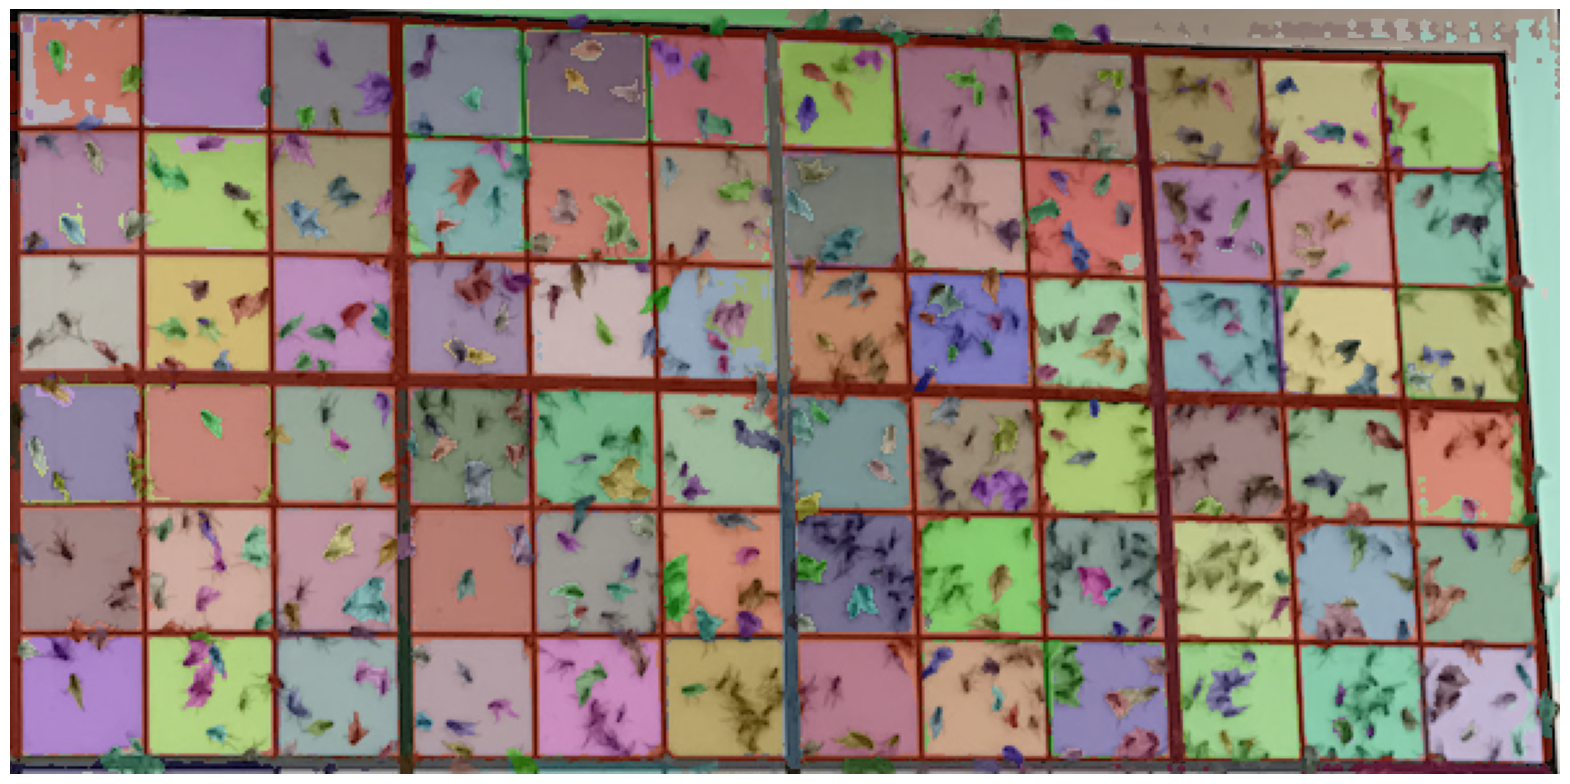

In [105]:
# Call the function with the image and model.
init_sam = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,  # Increased resolution for small objects
    points_per_batch=128,  # Increased batch size if GPU can handle it
    pred_iou_thresh=0.5,  # Lower IoU threshold for small object detection
    stability_score_thresh=0.9,  # High threshold for stable detections
    stability_score_offset=0.1,  # Small offset for stability score calculation
    box_nms_thresh=0.3,  # Lower NMS threshold for separating close objects
    crop_n_layers=0,  # No additional crop layers
    crop_nms_thresh=0.7,  # Default value, not used if crop_n_layers is 0
    crop_overlap_ratio=512 / 1500,  # Default value, not used if crop_n_layers is 0
    crop_n_points_downscale_factor=1,  # No downscale, using single layer detection
    point_grids=None,  # No custom point grids
    min_mask_region_area=3,  # Minimum area for detected objects
    output_mode="binary_mask"  # Binary mask for post-processing
)
masks = init_sam.generate(image)
filtered_data_list = [masks]
for mask in total_masks:
    filtered_data = filter_data_by_percentile(masks, "area", 0.80)
    filtered_data_list.append(filtered_data)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(filtered_data_list[0])
plt.axis('off')
plt.show() 

In [108]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 1955,
 'bbox': [5, 3, 93, 41],
 'predicted_iou': 1.0164767503738403,
 'point_coords': [[98.4375, 39.3125]],
 'stability_score': 0.9954081773757935,
 'crop_box': [0, 0, 600, 296]}

In [126]:
import json
filtered_masks = []
for mask in masks:
    aux_mask = mask
    aux_mask.pop('segmentation', None)
    filtered_masks.append(aux_mask)

with open('masks_2.json', 'w') as f:
    json.dump(filtered_masks, f, indent=4)

In [128]:
mask_without_segmentation = [{key: value for key, value in mask.items() if key != "segmentation"} for mask in masks]
print(mask_without_segmentation)

[{'area': 1955, 'bbox': [5, 3, 93, 41], 'predicted_iou': 1.0164767503738403, 'point_coords': [[98.4375, 39.3125]], 'stability_score': 0.9954081773757935, 'crop_box': [0, 0, 600, 296]}, {'area': 1932, 'bbox': [156, 194, 44, 46], 'predicted_iou': 1.0045620203018188, 'point_coords': [[173.4375, 228.9375]], 'stability_score': 0.9963805675506592, 'crop_box': [0, 0, 600, 296]}, {'area': 1992, 'bbox': [53, 146, 47, 43], 'predicted_iou': 0.996350109577179, 'point_coords': [[70.3125, 150.3125]], 'stability_score': 0.9979940056800842, 'crop_box': [0, 0, 600, 296]}, {'area': 1755, 'bbox': [153, 6, 43, 42], 'predicted_iou': 0.9929758310317993, 'point_coords': [[182.8125, 34.6875]], 'stability_score': 0.996588945388794, 'crop_box': [0, 0, 600, 296]}, {'area': 1746, 'bbox': [489, 63, 45, 41], 'predicted_iou': 0.9927381277084351, 'point_coords': [[520.3125, 71.6875]], 'stability_score': 0.9959999918937683, 'crop_box': [0, 0, 600, 296]}, {'area': 2014, 'bbox': [53, 96, 46, 43], 'predicted_iou': 0.9919